In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import re
from itertools import chain 

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from scipy import sparse
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def get_bow(data, encoder):
    bows = []
    for ex in data:
        encoded = [encoder.get(w, 1) for w in ex]
        x = to_categorical(encoded, num_classes=len(encoder))
        x = np.sum(x, axis=0)
        bows.append(x)
    return np.array(bows)


In [3]:
def is_noun(word, tag):
    return (tag == "NN" or tag == "NNS") and word.isalpha() and len(word) > 1


In [4]:
def get_wordnet_repr(word):
    synset = wn.synsets(word, "n")
    if len(synset) > 0:
        return synset[0]
    else:
        return None

In [5]:
def preprocess_sentence(sent):
    sent = sent.strip()
    # delete unwanted special characters
    sent = re.sub(r"[@#\^\*\(\)\\\|~;\"=+`]", "", sent)

    # handle some special characters
    sent = sent.replace("$", " dollar ")
    sent = sent.replace("%", " percent ")
    sent = sent.replace("&", " and ")
    sent = re.sub("[-_:]", " ", sent)
    sent = sent.lower()
    
    return sent

In [6]:
class Dataset:
    def __init__(self, mode="train", stem_func=None, tag_func=nltk.pos_tag):
        if stem_func is not None:
            self.stem_func = stem_func
        else:
            self.stem_func = lambda x: x

        self.tag_func = tag_func
        self.mode = mode

        self.word2idx = None
        self.idx2word = None
        self.similarity_matrix = None

    def get_corpus(self):
        """List of Dialogues. Each dialogue is list of sentences (question and answer 
        are separate sentences). Each sentece is tokenized.
        """
        corpus = []
        with open(f"drive/MyDrive/task/data/dialog_{self.mode}.txt") as f:
            for line in f:
                line = preprocess_sentence(line)

                # simple heuristic to avoid mistake in pos tagging
                line = line.replace("yes", "Yes")

                line = line.replace("</q>", "?")
                line = line.replace("</a>", ".")

                # split by sentence
                line = re.split("<[qa]>", line)
                # drop empty strings created from split, and tokenize
                line = [nltk.word_tokenize(s) for s in line if s]
                corpus.append(line)

        print("finished loading corpus")
        return corpus

    def get_description(self):
        """List of descriptions. The descriptions are tokenized."""
        with open(f"drive/MyDrive/task/data/desc_{self.mode}.txt") as f:
            descriptions = []
            for line in f:
                line = preprocess_sentence(line)
                line = nltk.word_tokenize(line)
                descriptions.append(line)

        print("finished loading descriptions")
        return descriptions

    def extract_nouns(self, tagged_sentence):
        nouns = []
        for w in tagged_sentence:
            if not is_noun(*w):
                continue
            synset = get_wordnet_repr(w[0])
            if synset is None:
                continue
            nouns.append(synset.name())
        return nouns


    def extract_context(self, corpus):
        """Context from dialogues. 
        shape: [number of dialogue, number of context]"""
        contexts = []
        for i, dialog in enumerate(corpus):
            tagged_dialog = self.tag_func(dialog)
            context = set()
            for sent in tagged_dialog:
                nouns = self.extract_nouns(sent)
                context.update(nouns)
            contexts.append(list(context))

        print("finished extracting contexts")
        return contexts
    
    def extract_target(self, description, contexts):
        """Extract ground truth OOC.

        NOTE: There are quite a lot of instances there is no OOC.
        """
        targets = []
        tagged_description = self.tag_func(description)
        for i, desc in enumerate(tagged_description):
            nouns = self.extract_nouns(desc)
            ooc = set(nouns) - set(contexts[i])
            targets.append(list(ooc))

        print("finished extracting targets (OOCs)")
        return targets
    
    def set_vocab(self, context, target):
        """Vocabulary of the dataset."""
        vocab = set()
        vocab.update(chain.from_iterable(context))
        vocab.update(chain.from_iterable(target))

        self.word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
        self.word2idx["[pad]"] = 0
        self.word2idx["[unk]"] = 1

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
    

    def set_similarity_matrix(self):
        self.similarity_matrix = sparse.lil_matrix((len(self.word2idx), len(self.word2idx)))  # [V, V]

        for i, word1 in self.idx2word.items():
            if i in [0, 1]:
                continue

            w1 = wn.synset(word1)
            for j, word2 in self.idx2word.items():
                if j in [0, 1]:
                    continue
                if j == i:
                    self.similarity_matrix[i, j] = -1
                    continue

                w2 = wn.synset(word2)
                similarity = w1.wup_similarity(w2)
                if similarity is None:
                    similarity = 0

                self.similarity_matrix[i, j] = similarity
            if i % 100 == 0:
                print(i)
        self.similarity_matrix = self.similarity_matrix.tocsr()


        print("finished setting up similarity matrix")



    def get_data_target(self, word2idx=None, sim_mat=None):
        corpus = self.get_corpus()  #[N, D, t]
        description = self.get_description()  #[N, D]

        contexts = self.extract_context(corpus)  # [N, t]
        target = self.extract_target(description, contexts)  # [N, G]

        if word2idx is None:
            self.set_vocab(contexts, target)
            self.set_similarity_matrix()
            word2idx = self.word2idx
            sim_mat = self.similarity_matrix

        # similarity data
        sim_idx = [[word2idx.get(tok, 1) for tok in dialog] for dialog in contexts]  # [N, t]
        sim = [sim_mat[idx].sum(0) for idx in sim_idx]
        sim = np.vstack(sim)

        # input data
        data = [list(chain.from_iterable(dialog)) for dialog in corpus]
        if self.mode == "train":
            tokenizer.fit_on_texts(data)
        data = [list(chain.from_iterable(tokenizer.texts_to_sequences(dialog))) for dialog in corpus]
        maxlen = 260
        data = np.array([np.pad(ex, (0, maxlen - len(ex))) for ex in data])
        print(data.shape)

        target_label = get_bow(target, word2idx)  # [N, V]

        defined_idx = np.where(target_label.sum(1) > 0)[0]

        return sim[defined_idx], data[defined_idx], target_label[defined_idx]

In [7]:
from nltk.tag import StanfordPOSTagger

STANFORD_POS_MODEL_PATH = "/content/drive/MyDrive/stanford-postagger-full-2020-11-17/models/english-bidirectional-distsim.tagger"
STANFORD_POS_JAR_PATH = "/content/drive/MyDrive/stanford-postagger-full-2020-11-17/stanford-postagger-4.2.0.jar"

pos_tagger = StanfordPOSTagger(STANFORD_POS_MODEL_PATH, STANFORD_POS_JAR_PATH)

lemma = nltk.wordnet.WordNetLemmatizer()

tokenizer = Tokenizer(oov_token="[UNK]")

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


In [8]:
def load_word2idx(path):
    word2idx = {}
    with open(path, "r") as f:
        for line in f:
            word, idx = line.split(",")
            word2idx[word] = int(idx)
    return word2idx

In [9]:
train_ds = Dataset(mode="train", stem_func=lemma.lemmatize, tag_func=nltk.pos_tag_sents)
val_ds = Dataset(mode="valid", stem_func=lemma.lemmatize, tag_func=nltk.pos_tag_sents)

In [10]:
word2idx = load_word2idx("/content/drive/MyDrive/word2idx.txt")
sim_mat = sparse.load_npz("/content/drive/MyDrive/sim_mat.npz")

In [11]:
train_sim, train_data, train_target = train_ds.get_data_target(word2idx, sim_mat)
val_sim, val_data, val_target = val_ds.get_data_target(word2idx, sim_mat)

finished loading corpus
finished loading descriptions
finished extracting contexts
finished extracting targets (OOCs)
(9666, 260)
finished loading corpus
finished loading descriptions
finished extracting contexts
finished extracting targets (OOCs)
(1208, 260)


top.n.01
man.n.01
group.n.01
field.n.01
front.n.01
person.n.01
woman.n.01
couple.n.01
street.n.01
side.n.01
table.n.01
room.n.01
baseball.n.01
people.n.01
food.n.01
road.n.01
area.n.01
game.n.01
city.n.01
tennis.n.01
picture.n.01
kitchen.n.01
bathroom.n.01
air.n.01
beach.n.01
child.n.01
bunch.n.01
life.n.02
grass.n.01
computer.n.01
building.n.01
work_force.n.01
herd.n.01
fire.n.01
ocean.n.01
position.n.03
home_plate.n.01
player.n.01
ball.n.01
background.n.01
water.n.01
tons.n.01
cell.n.01
piece.n.01
land.n.04
board.n.01
park.n.01
skateboard.n.01
snow.n.01
photograph.n.01


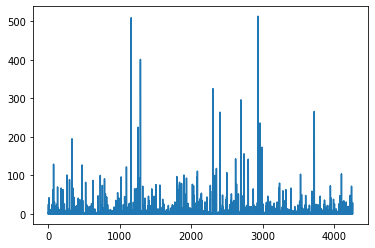

In [77]:
import matplotlib.pyplot as plt

plt.plot(train_target.sum(0))
most_seen = train_target.sum(0).argsort()[::-1][:50]

for i in most_seen:
    print(idx2word[i])

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_sim)
train_sim = scaler.transform(train_sim)
val_sim = scaler.transform(val_sim)

## Debug

In [ ]:
train_corpus = train_ds.get_corpus()
train_description = train_ds.get_description()

finished loading corpus
finished loading descriptions


In [ ]:
train_context = train_ds.extract_context(train_corpus)
train_target = train_ds.extract_target(train_description, train_context)

finished extracting contexts
finished extracting targets (OOCs)


In [ ]:
x = zip(train_context, train_target)
next(x)

(['grey.n.01',
  'bus.n.01',
  'ad.n.01',
  'photograph.n.01',
  'top.n.01',
  'woman.n.01',
  'color.n.01',
  'yoga.n.01',
  'bloomers.n.01'],
 ['tour.n.01', 'business_district.n.01'])

In [ ]:
next(x)

(['hair.n.01',
  'man.n.01',
  'clean_and_jerk.n.01',
  'shirt.n.01',
  'color.n.01',
  'position.n.03',
  'wood.n.01',
  'laptop.n.01',
  'taste.n.01',
  'wear.n.01',
  'spectacles.n.01',
  'screen.n.01',
  'beard.n.01',
  'model.n.01',
  'brown.n.01',
  'table.n.01'],
 ['work.n.01', 'people.n.01'])

In [ ]:
train_ds.set_vocab(train_context, train_target)
print("vocab_size:", len(train_ds.word2idx))

train_ds.set_similarity_matrix()

vocab_size: 4263
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
finished setting up similarity matrix


In [ ]:
# TODO: change this part
data_idx = [[train_ds.word2idx.get(tok, 1) for tok in dialog] for dialog in train_context]  # [N, t]
train_data = [train_ds.similarity_matrix[idx].sum(axis=0) for idx in data_idx]  # [N, V]
train_data = np.vstack(train_data)
print(train_data.shape)

train_target_label = get_bow(train_target, train_ds.word2idx)  # [N, V]

defined_idx = np.where(train_target_label.sum(1) > 0)[0]

train_data, train_target_label = train_data[defined_idx], train_target_label[defined_idx]

(9666, 4263)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)

## Save

In [ ]:
with open("/content/drive/MyDrive/word2idx.txt", "w") as f:
    for k, v in train_ds.word2idx.items():
        f.write(f"{k}, {v}\n")

sparse.save_npz("/content/drive/MyDrive/sim_mat", train_ds.similarity_matrix)

## Model

In [13]:
vocab_size = len(tokenizer.word_index) + 1

x = keras.layers.Input(shape=(train_data.shape[1],))  # [N, V]
s = keras.layers.Input(shape=(train_sim.shape[1],))

e = keras.layers.Embedding(vocab_size, 256)(x)
h = keras.layers.LSTM(256, return_sequences=True)(e)
h = keras.layers.LSTM(1024)(h)
h_final = keras.layers.Dense(train_target.shape[-1], activation="sigmoid")(h)
sum = h_final + s
y = keras.layers.Dense(train_target.shape[-1], activation="sigmoid")(sum)

model = keras.models.Model(inputs=(x, s), outputs=y)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.fit((train_data, train_sim), train_target, validation_data=((val_data, val_sim), val_target), batch_size=32, epochs=10)

Epoch 1/10
270/270 [==============================] - 44s 146ms/step - loss: 0.3146 - accuracy: 8.7216e-05 - val_loss: 0.0119 - val_accuracy: 0.0297
Epoch 2/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0094 - accuracy: 0.0363 - val_loss: 0.0059 - val_accuracy: 0.0241
Epoch 3/10
270/270 [==============================] - 40s 149ms/step - loss: 0.0055 - accuracy: 0.0238 - val_loss: 0.0046 - val_accuracy: 0.0213
Epoch 4/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0045 - accuracy: 0.0216 - val_loss: 0.0041 - val_accuracy: 0.0204
Epoch 5/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0041 - accuracy: 0.0236 - val_loss: 0.0038 - val_accuracy: 0.0204
Epoch 6/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0038 - accuracy: 0.0268 - val_loss: 0.0037 - val_accuracy: 0.0297
Epoch 7/10
270/270 [==============================] - 40s 148ms/step - loss: 0.0037 - accuracy: 0.0322 - val_loss: 0.0036 - va

## Predictions

In [50]:
idx2word = {idx: word for word, idx in word2idx.items()}

In [51]:
x = 6
pred = model((np.expand_dims(train_data[x], axis=0), train_sim[x])).numpy()
top10 = pred.flatten().argsort()[-10:][::-1]

print("pred\n")
for i in top10:
    print(idx2word[i], pred[0, i])

print("\ntarget\n")
for i in np.where(train_target[x] == 1)[0]:
    print(idx2word[i])

# print("\ninput\n")
# for i in train_contexts[x]:
#     print(i)

pred

top.n.01 0.05511457
man.n.01 0.04823683
group.n.01 0.02726137
field.n.01 0.026218083
front.n.01 0.024757821
person.n.01 0.02388316
couple.n.01 0.022019172
woman.n.01 0.021152735
street.n.01 0.015534952
table.n.01 0.015146079

target

field.n.01


In [20]:
from sklearn.metrics import recall_score, f1_score, precision_score

In [65]:
def top_k_metric(pred, gt, k, mode="macro"):
    topk_idx = pred.argsort()[:, ::-1][:, :k]
    y_hat = np.zeros(pred.shape)
    for i in range(topk_idx.shape[0]):
        y_hat[i, topk_idx[i]] = 1
    return precision_score(gt, y_hat, average=mode), recall_score(gt, y_hat, average=mode), f1_score(gt, y_hat, average=mode)

In [58]:
pred = model.predict((train_data, train_sim), batch_size=32)

In [69]:
for i in range(1, 11):
    metric = top_k_metric(pred, train_target, i, mode="weighted")
    print(f"top {i}: \nprecision: {metric[0]}\nrecall: {metric[1]}\nf1: {metric[2]}")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


top 1: 
precision: 0.002669686946718441
recall: 0.02725769456446365
f1: 0.0031690522289403032
top 2: 
precision: 0.0032347643497243504
recall: 0.0545153891289273
f1: 0.0061071454815039925
top 3: 
precision: 0.005665440976172632
recall: 0.07606550381394356
f1: 0.009092010938626018
top 4: 
precision: 0.006371775806789518
recall: 0.09857577212353977
f1: 0.011425433882829935
top 5: 
precision: 0.005935321852242278
recall: 0.10967088067424122
f1: 0.011159869488732306
top 6: 
precision: 0.006181374129113079
recall: 0.1232197151544247
f1: 0.011266653925077244
top 7: 
precision: 0.006692151615599381
recall: 0.13676854963460822
f1: 0.01272264226998189
top 8: 
precision: 0.006645869275668957
recall: 0.14989064917053396
f1: 0.012686351226289454
top 9: 
precision: 0.007066887355415402
recall: 0.16194591134581532
f1: 0.013407341724187682
top 10: 
precision: 0.007266192729354407
recall: 0.17117405451538914
f1: 0.013800786900920105
